In [25]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras

In [4]:
import pandas as pd

In [5]:
df_gases_train = pd.read_pickle("./data_gases_train.pkl")
df_stitch_1_train = pd.read_pickle("./data_stitch_1_train.pkl")

In [13]:
df_gases_train = df_gases_train[['Um','Ur','Ud','C_target']]
df_stitch_1_train = df_stitch_1_train[['Um','Ur','Ud','C_target']]

In [14]:
df_gases_train.shape

(2437, 4)

In [15]:
df_stitch_1_train.shape

(1252, 4)

In [16]:
df_gases_train[df_gases_train['C_target'] == 0].shape

(937, 4)

In [18]:
additional_nonezero_objs = df_gases_train[df_gases_train['C_target'] != 0].sample(frac = 0.6, replace = False)
df_stitch_1_train_shrinked = df_stitch_1_train.sample(frac = 0.5)
df = pd.concat([df_gases_train, df_stitch_1_train_shrinked, additional_nonezero_objs])

In [84]:
features = df[['Um','Ur','Ud']]
target = df['C_target']

In [23]:
def set_nonelinear_features(features):
    features['Um^2'] = features['Um'].pow(2)
    features['Um^3'] = features['Um'].pow(3)
    features[f'ln(Um)'] = np.log(features['Um'])
    features['Ur^2'] = features['Ur'].pow(2)
    features['Ur^3'] = features['Ur'].pow(3)
    features['Ud^2'] = features['Ud'].pow(2)
    features['Ud^3'] = features['Ud'].pow(3)
    features['Um/Ur'] = features['Um']/features['Ur']
    features['Um/Ud'] = features['Um']/features['Ud']
    return features

In [26]:
features = set_nonelinear_features(features)
features.head(1)

,Um,Ur,Ud,Um^2,Um^3,ln(Um),Ur^2,Ur^3,Ud^2,Ud^3,Um/Ur,Um/Ud
0,0.70109,0.70087,0.77666,0.491527,0.344605,-0.355119,0.491219,0.34428,0.603201,0.468482,1.000314,0.902699


In [28]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
features_train, features_val, target_train, target_val = train_test_split(features, target,
                                                                          test_size=0.1, random_state=42, shuffle=True)
scaler = preprocessing.StandardScaler().fit(features_train)
features_train = scaler.transform(features_train) 
features_val = scaler.transform(features_val)

In [36]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras import regularizers
from keras.layers import Dropout

Using TensorFlow backend.


In [37]:
from keras.layers import BatchNormalization

In [45]:
target_val.reset_index(drop=True, inplace=True)

In [106]:
input_size = features_train.shape[1]
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
valid_set = [(features_val[i], target_val[i]) for i in range(0, target_val.size)]

one_layer_models = {}
two_layers_models = {}
optimizer = keras.optimizers.RMSprop(0.05)

for neurs_numb in range(4,24,6):
    one_layer_models[f'one_layer_model_{neurs_numb}'] = Sequential([
        Dense(neurs_numb, activation='relu', input_shape=(input_size,), kernel_regularizer=regularizers.l1(0.001)),
        Dense(1)
      ])
    one_layer_models[f'one_layer_model_{neurs_numb}'].compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])

In [57]:
target_train = target_train.to_numpy()
target_val = target_val.to_numpy()

In [107]:
one_layer_models_history = [(key, one_layer_models[key].fit(features_train, target_train, epochs=2000, batch_size = 200, shuffle=True,
                    validation_data=(features_val, target_val), verbose=0, callbacks=[early_stop])) for key in one_layer_models.keys()]

In [163]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
for neurs_numb_fst_layer in range(8,20,6):
    for neurs_numb_scd_layer in range(neurs_numb_fst_layer + 4,int(neurs_numb_fst_layer*0.66),-6):
        two_layers_models[f'two_layers_model_{neurs_numb_fst_layer}_{neurs_numb_scd_layer}'] = Sequential([
            Dense(neurs_numb_fst_layer, activation='relu', input_shape=(input_size,), kernel_regularizer=regularizers.l1(0.001)),
            Dense(neurs_numb_scd_layer, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
            Dense(1)
          ])
        two_layers_models[f'two_layers_model_{neurs_numb_fst_layer}_{neurs_numb_scd_layer}'].compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])

In [164]:
two_layers_models_history = [(key, two_layers_models[key].fit(features_train, target_train, epochs=2000, batch_size = 200, shuffle=True,
                    validation_data=(features_val, target_val), verbose=0, callbacks=[early_stop])) for key in two_layers_models.keys()]

In [120]:
import matplotlib.pyplot as plt

In [168]:
color_map =['red','blue','purple', 'green', 'black', 'yellow','brown', 'grey', 'orange','plum' , 'khaki', 'indigo']

In [171]:
def plot_history(history, xlim):    
    plt.figure(figsize=(40,20))
    for i in range(0,len(history)):
        model_name = history[i][0]
        hist = history[i][1].history
        epoch = history[i][1].epoch
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error [$MPG^2$]')
        plt.plot(epoch, hist['mse'], ms=1.5, color=color_map[i],
           label=f'{model_name}_train')
        plt.plot(epoch, hist['val_mse'], color=color_map[i],
           label = f'{model_name}_val', ms=1.5, linestyle = '--')
        plt.ylim([0,3000000])
        plt.xlim([0,xlim])
    plt.legend(fontsize=24, markerscale=10)
    plt.show()

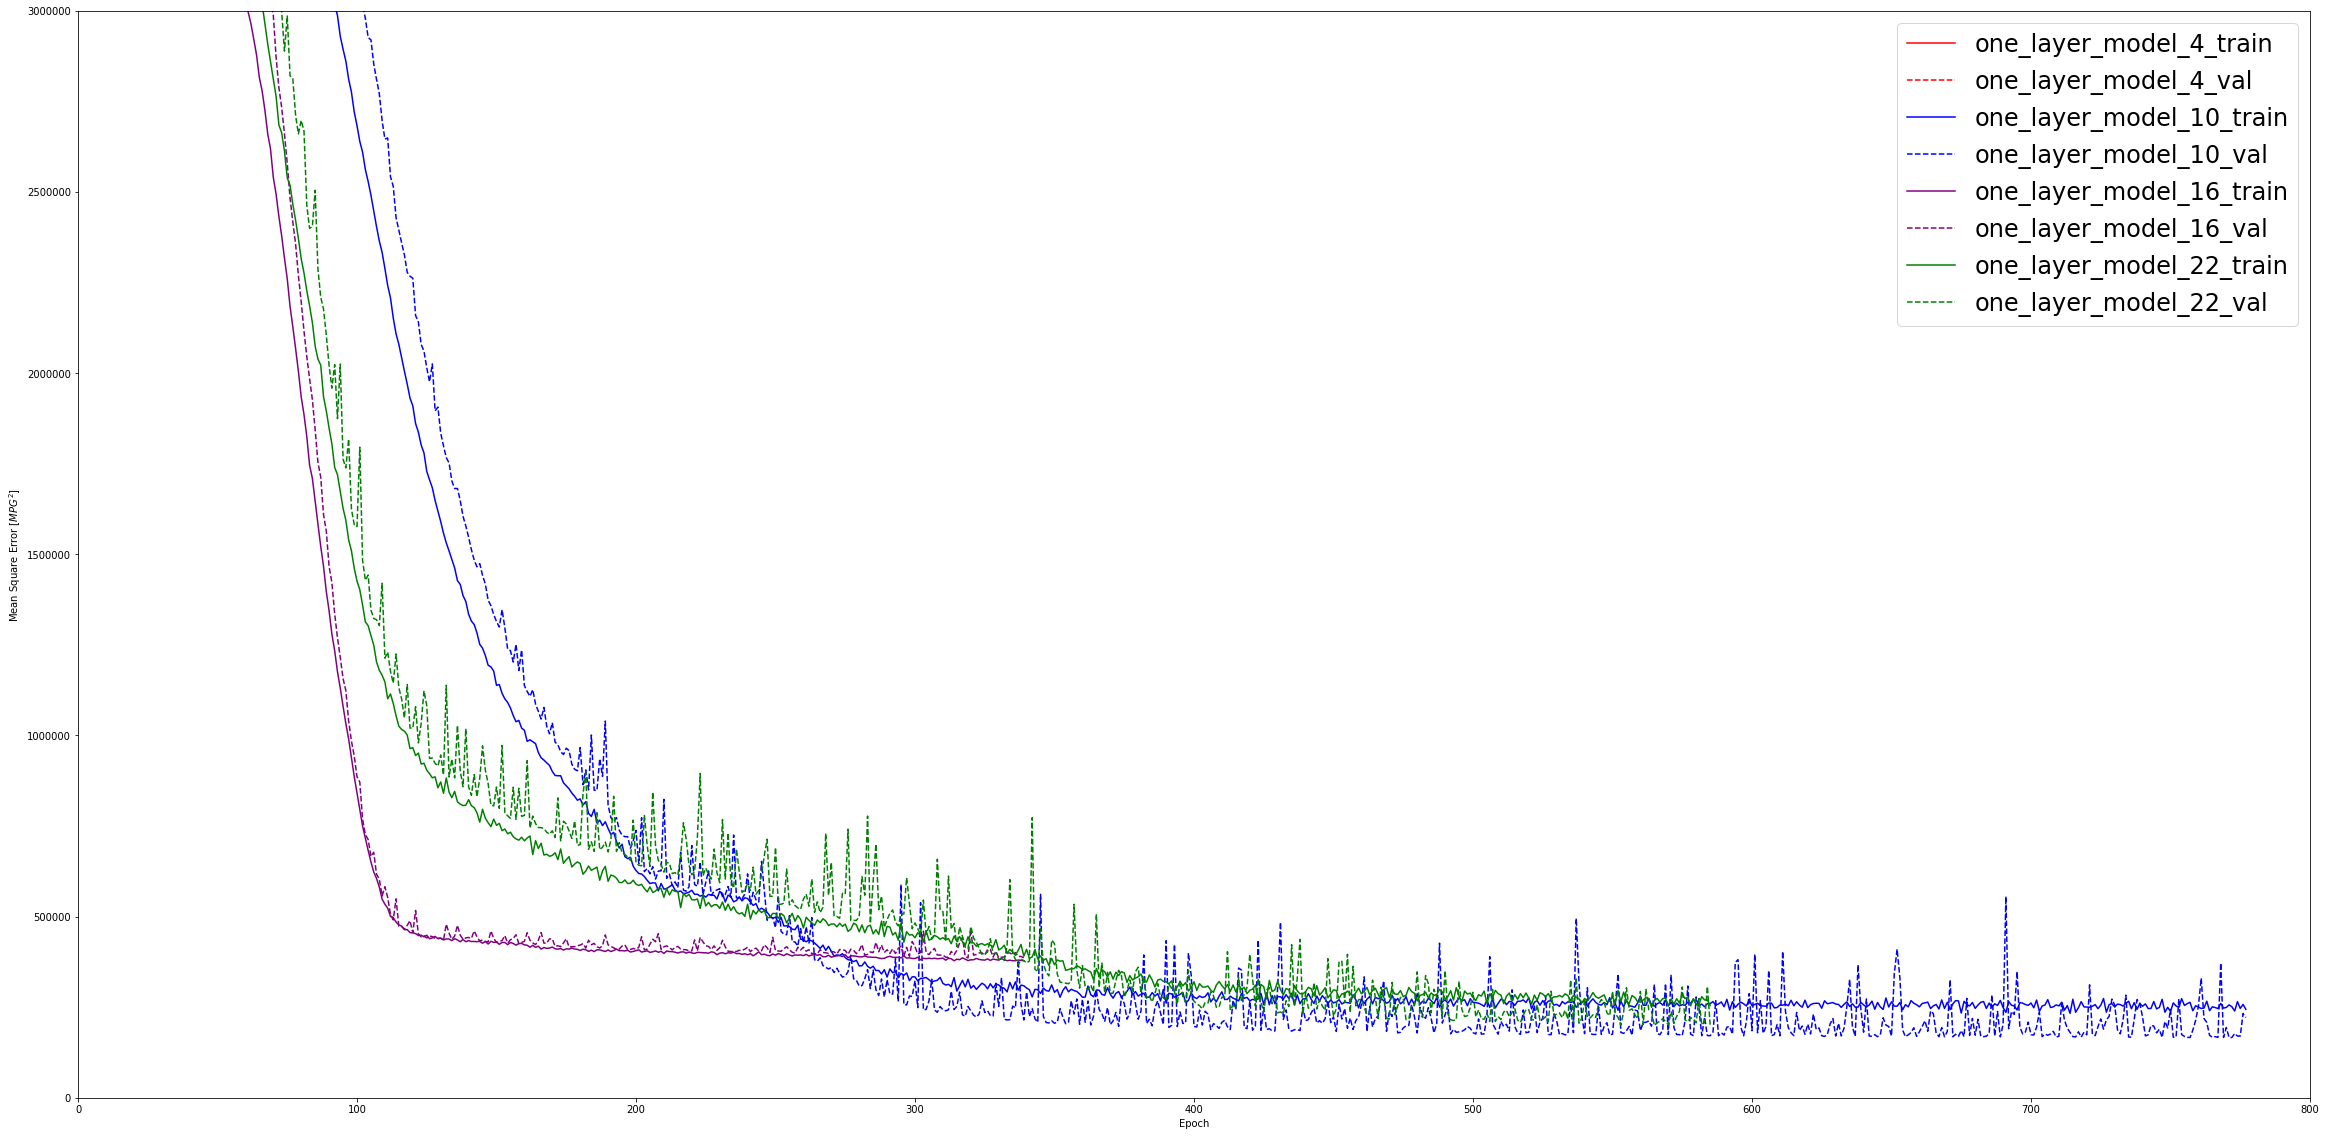

In [172]:
plot_history(one_layer_models_history, 800)

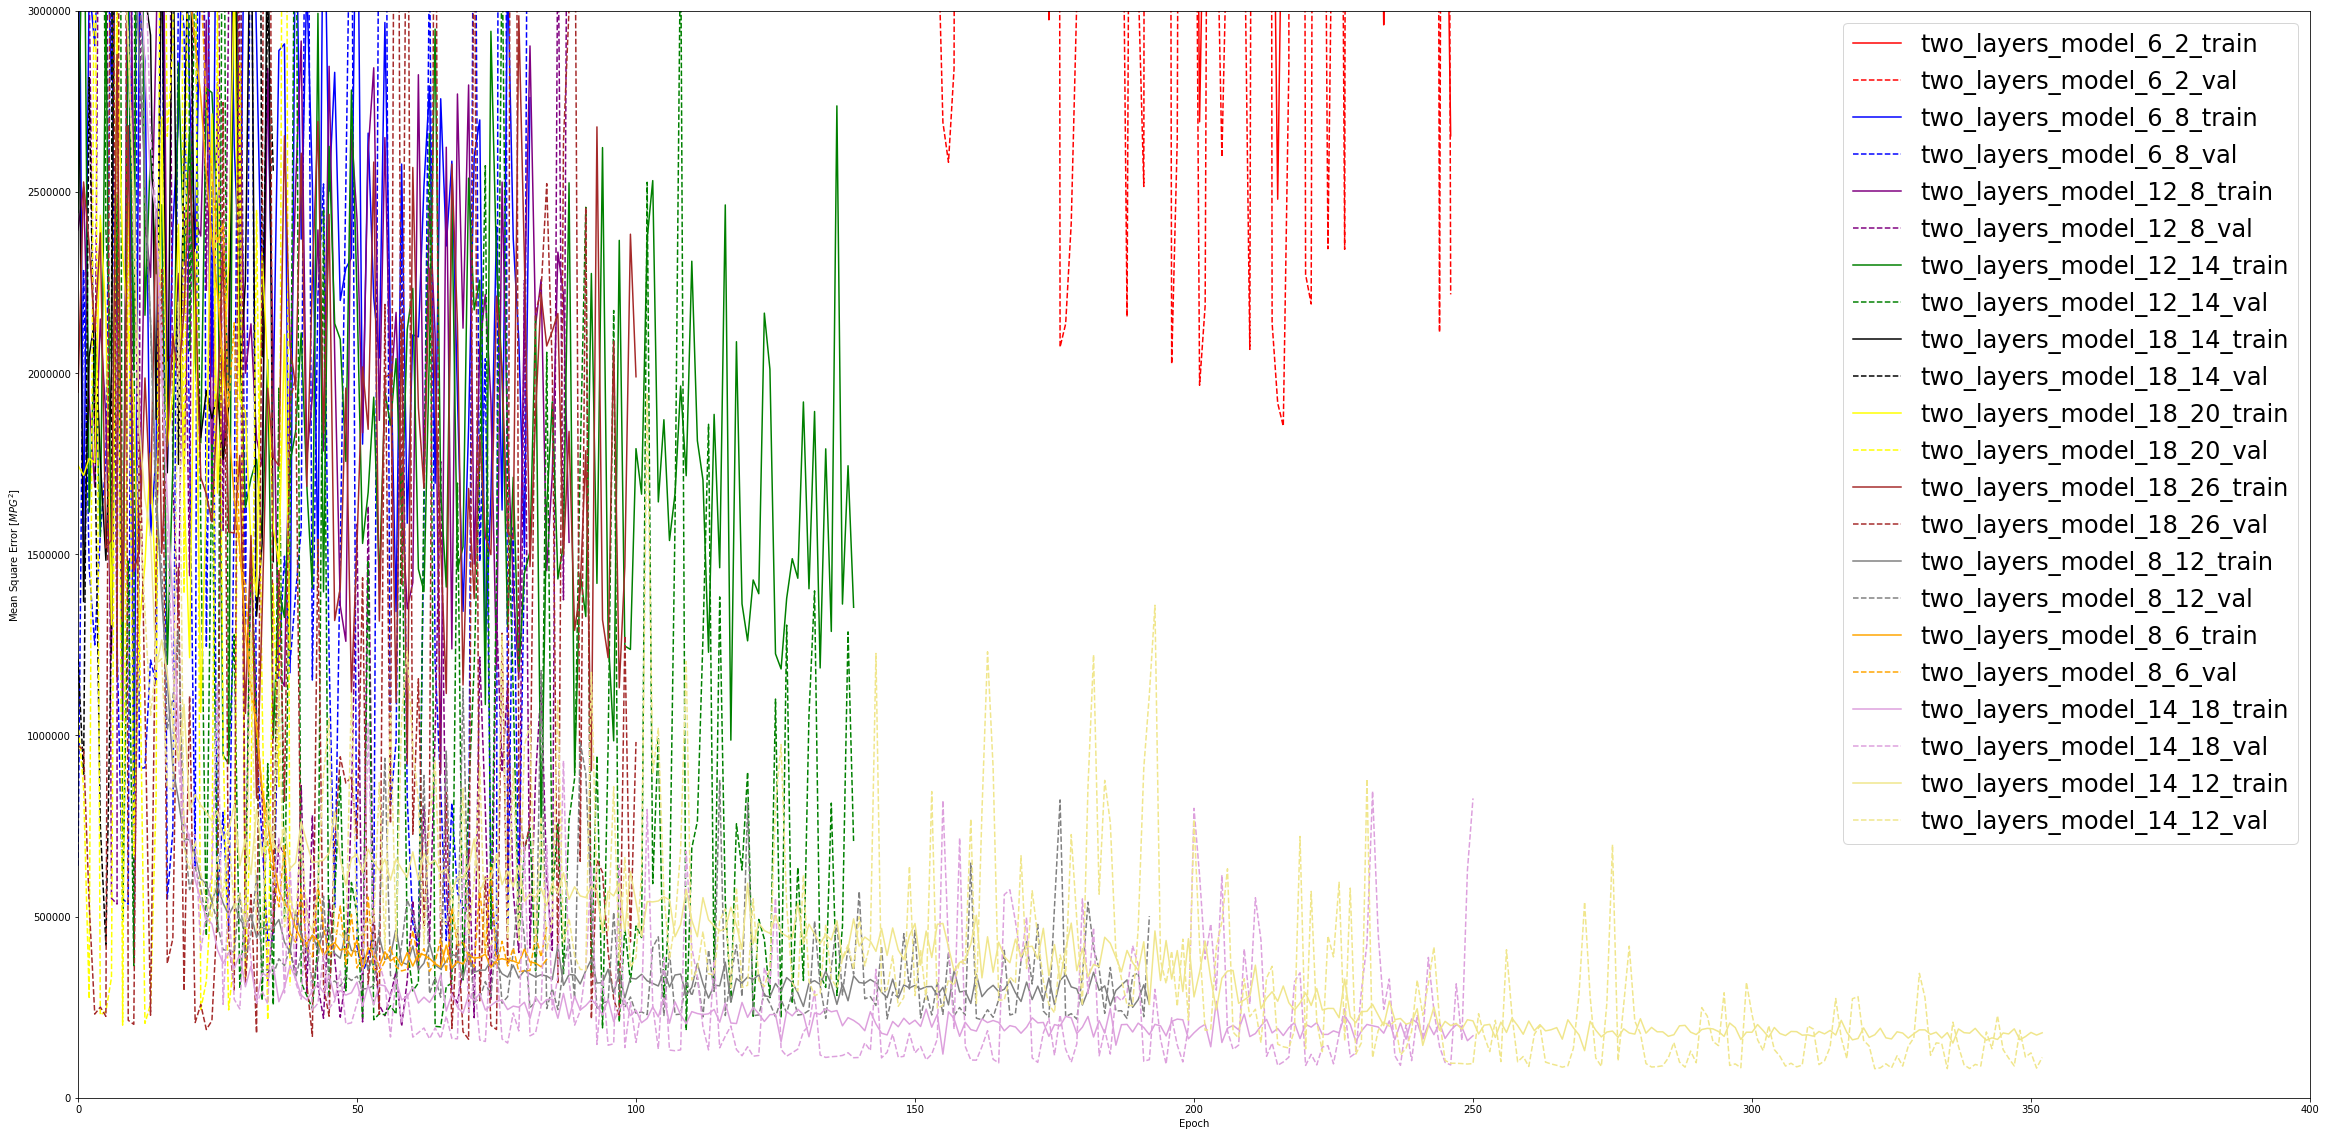

In [173]:
plot_history(two_layers_models_history, 400)

In [177]:
best_two_layers_model = two_layers_models_history[-1]
best_two_layers_model[0]

'two_layers_model_14_12'

In [175]:
one_layer_model_22 = one_layer_models_history[-1]
one_layer_model_10 = one_layer_models_history[-3]

In [179]:
best_two_layers_model_hist = pd.DataFrame(best_two_layers_model[1].history)
best_two_layers_model_hist['epoch'] = best_two_layers_model[1].epoch
best_two_layers_model_hist.tail(10)

,val_loss,val_mse,loss,mse,epoch
343,135492.231030,135489.671875,165375.271444,165372.718750,343
344,226816.441121,226813.890625,161070.610190,161068.062500,344
345,132968.017750,132965.453125,178874.355278,178871.781250,345
346,109400.167467,109397.601562,176211.204483,176208.656250,346
347,88005.477763,88002.921875,190267.099919,190264.515625,347
348,186425.977251,186423.421875,160237.370031,160234.828125,348
349,112676.245316,112673.671875,168866.156942,168863.593750,349
350,123887.056085,123884.484375,180389.944327,180387.375000,350
351,81979.929353,81977.359375,173041.249676,173038.687500,351
352,111185.629388,111183.054688,179355.568555,179353.000000,352


In [181]:
one_layer_model_22_hist = pd.DataFrame(one_layer_model_22[1].history)
one_layer_model_22_hist['epoch'] = one_layer_model_22[1].epoch
one_layer_model_22_hist.tail(10)

,val_loss,val_mse,loss,mse,epoch
576,214612.232997,214606.687500,273737.592199,273732.031250,576
577,210719.220324,210713.671875,277715.129241,277709.593750,577
578,221522.853983,221517.296875,253995.788068,253990.234375,578
579,216103.952810,216098.421875,273410.769761,273405.218750,579
580,207017.240043,207011.703125,256901.480528,256895.921875,580
581,273877.975913,273872.437500,259018.105072,259012.562500,581
582,201097.196395,201091.640625,279209.072893,279203.531250,582
583,208861.410776,208855.859375,269963.586792,269958.031250,583
584,307101.393341,307095.843750,270400.914382,270395.343750,584
585,201731.688090,201726.140625,254568.430086,254562.875000,585


In [182]:
one_layer_model_10_hist = pd.DataFrame(one_layer_model_10[1].history)
one_layer_model_10_hist['epoch'] = one_layer_model_10[1].epoch
one_layer_model_10_hist.tail(10)

,val_loss,val_mse,loss,mse,epoch
768,371704.429550,371700.906250,260528.490448,260525.000000,768
769,166540.904872,166537.406250,247509.791275,247506.281250,769
770,193961.127204,193957.640625,249281.307838,249277.828125,770
771,166323.941633,166320.453125,256485.000806,256481.531250,771
772,166379.068561,166375.593750,251235.632563,251232.156250,772
773,177436.295852,177432.812500,239438.082594,239434.593750,773
774,170386.900228,170383.421875,265426.239055,265422.750000,774
775,170403.899599,170400.406250,246591.399467,246587.890625,775
776,232720.995592,232717.500000,257660.840402,257657.343750,776
777,221666.840523,221663.359375,244179.196868,244175.703125,777


In [183]:
df_gases_2_test = pd.read_pickle("./data_gases_2_test.pkl")
C_target_test = df_gases_2_test['C_target']
C_original_unbiased = df_gases_2_test['C'] - 110.4721
features_test = df_gases_2_test[['Um','Ur','Ud']]
features_test = set_nonelinear_features(features_test)
features_test = scaler.transform(features_test)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [184]:
features_test

array([[ 0.26417938,  0.1489825 ,  0.15390034, ...,  0.14304839,
         0.00264144,  0.2955919 ],
       [ 0.26456491,  0.1582488 ,  0.16701548, ...,  0.15645838,
        -0.01930178,  0.29314925],
       [ 0.24258987,  0.13266273,  0.12111249, ...,  0.10954459,
         0.00483871,  0.27704244],
       ...,
       [ 0.20750691,  0.10182114,  0.0976926 , ...,  0.08563181,
         0.01903827,  0.24026741],
       [ 0.25781818,  0.15105704,  0.14827956, ...,  0.13730273,
        -0.01352371,  0.28923393],
       [-0.58802815, -0.10604842,  0.02181215, ...,  0.00826032,
        -0.88501762, -0.69539667]])

In [188]:
best_two_layers_model_hist

,val_loss,val_mse,loss,mse,epoch
0,2.262290e+08,2.262290e+08,2.098285e+08,2.098285e+08,0
1,1.500930e+08,1.500930e+08,1.656187e+08,1.656187e+08,1
2,6.075489e+07,6.075488e+07,9.154454e+07,9.154453e+07,2
3,1.493221e+07,1.493221e+07,3.029060e+07,3.029060e+07,3
4,6.923763e+06,6.923762e+06,9.317748e+06,9.317746e+06,4
...,...,...,...,...,...
348,1.864260e+05,1.864234e+05,1.602374e+05,1.602348e+05,348
349,1.126762e+05,1.126737e+05,1.688662e+05,1.688636e+05,349
350,1.238871e+05,1.238845e+05,1.803899e+05,1.803874e+05,350
351,8.197993e+04,8.197736e+04,1.730412e+05,1.730387e+05,351


In [189]:
two_layers_predict = two_layers_models[best_two_layers_model[0]].predict(features_test,verbose=0)
one_layer_predict = one_layer_models[one_layer_model_22[0]].predict(features_test,verbose=0)

In [194]:
from sklearn.metrics import mean_squared_error
print(f'RMSE of unbiased original C  = {np.sqrt(mean_squared_error(C_original_unbiased, C_target_test))}')
print(f'RMSE of one layer NN prediction = {np.sqrt(mean_squared_error(one_layer_predict, C_target_test))}')
print(f'RMSE of two layers NN prediction = {np.sqrt(mean_squared_error(two_layers_predict, C_target_test))}')

RMSE of unbiased original C  = 600.6216093074637
RMSE of one layer NN prediction = 334.27021348905964
RMSE of two layers NN prediction = 277.30127316193216


In [191]:
df_stitch_2 = pd.read_pickle("./data_stitch_2.pkl")

In [192]:
df_stitch_2_sample = df_stitch_2.sample(1000)

In [193]:
C_target_stitch = df_stitch_2_sample['C_target']
features_stitch = df_stitch_2_sample[['Um','Ur','Ud']]
features_stitch = set_nonelinear_features(features_stitch)
features_stitch = scaler.transform(features_stitch)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [195]:
two_layers_predict_stitch = two_layers_models[best_two_layers_model[0]].predict(features_stitch,verbose=0)
one_layer_predict_stitch = one_layer_models[one_layer_model_22[0]].predict(features_stitch,verbose=0)
print(f'RMSE of one layer NN prediction on stitch = {np.sqrt(mean_squared_error(one_layer_predict_stitch, C_target_stitch))}')
print(f'RMSE of two layers NN prediction on stitch = {np.sqrt(mean_squared_error(two_layers_predict_stitch, C_target_stitch))}')

RMSE of one layer NN prediction on stitch = 1157.8468001677866
RMSE of two layers NN prediction on stitch = 1004.5404429302235


In [198]:
overview_stitch = pd.DataFrame({'C_pred': two_layers_predict_stitch.flatten(), 'C_target': C_target_stitch, 'Ur': df_stitch_2_sample['Ur']},
                             columns=[ 'C_pred', 'C_target', 'Ur'])

In [200]:
overview_stitch.reset_index(inplace=True)

In [202]:
overview_stitch.head(20)

,index,C_pred,C_target,Ur
0,2380,644.472351,0.0,0.45891
1,6895,-266.596252,0.0,0.64927
2,13988,63.515808,0.0,0.70066
3,1105,447.973816,0.0,0.53013
4,5488,-78.926086,0.0,0.61624
5,11993,303.882141,0.0,0.69514
6,5990,-132.761658,0.0,0.63007
7,3871,171.410095,0.0,0.55546
8,8515,1125.437866,0.0,0.67354
9,5124,-18.688295,0.0,0.60522


In [203]:
import os.path
if os.path.isfile('two_layers_model.h5') is False:
    two_layers_models[best_two_layers_model[0]].save_weights('two_layers_model.h5')

In [204]:
scaler.get_params()

{'copy': True, 'with_mean': True, 'with_std': True}

In [206]:
from sklearn.externals.joblib import dump, load
if os.path.isfile('std_scaler_for_nn.bin') is False:
    dump(scaler, 'std_scaler_for_nn.bin', compress=True)
#sc=load('std_scaler.bin')